In [157]:
p <- c("vegan", "reshape2","ggplot2","pheatmap","dplyr","randomForest", "ape",
       "plotly", "corrplot", "cowplot", "gridExtra", "grid")
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep=TRUE, repos="https://cloud.r-project.org/")
  suppressWarnings(suppressMessages(invisible(require(p, character.only=TRUE))))
}
invisible(lapply(p, usePackage))
source("metabo_util.R")
#-------------------------------


In [158]:
setwd('~/MyProjects/SoH_project/multi-omics')
outpath<-"All_heatmap_out/"
dir.create(outpath)

Warning message in dir.create(outpath):
“'All_heatmap_out' already exists”

## Data input

In [159]:
filename1<-"PlaqueMS275.txt"
prefix1<-"metabolomics"
metadata.filename1<-"PlaqueMS275_Map.txt"
filename2="SoH261.taxa.genus.Abd.OralCore.xls"
prefix2<-"microbiome-genus"
metadata.filename2<-"SoH261_Map.txt"
filename3<-"SoH192_cytokines.txt"
prefix3<-"cytokines"
metadata.filename3<-"SoH192_Map.txt"

f1<-read.table(filename1,header=TRUE,sep="\t",row.names=1, quote=""); f1<-f1[order(rownames(f1)), ]
f2<-read.table(filename2,header=TRUE,sep="\t",row.names=1); f2<-f2[order(rownames(f2)), ]
f3<-read.table(filename3,header=TRUE,sep="\t",row.names=1); f3<-f3[order(rownames(f3)), ]
m1<-read.table(metadata.filename1,header=T,sep="\t",row.names=1); m1<-m1[order(rownames(m1)), ]
m2<-read.table(metadata.filename2,header=T,sep="\t",row.names=1); m2<-m2[order(rownames(m2)), ]
m3<-read.table(metadata.filename3,header=T,sep="\t",row.names=1); m3<-m3[order(rownames(m3)), ]

cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1), rownames(m1)), "\n")
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2), rownames(m2)), "\n")
cat("The order of samples in the cytokines data and metadata are equal:", all.equal(rownames(f3), rownames(m3)))


The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 
The order of samples in the cytokines data and metadata are equal: TRUE

## To identify intersected sample IDs

In [160]:

Shared_SampleIDs<-intersect(rownames(f1), rownames(f2))
f1_s<-f1[Shared_SampleIDs,]; 
m1_s<-m1[Shared_SampleIDs,]; 
cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1_s), rownames(m1_s)), "\n")
f2_s<-f2[Shared_SampleIDs,]; 
m2_s<-m2[Shared_SampleIDs,]; 
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2_s), rownames(m2_s)), "\n")
#library("graphics")
dt<-table(m2[, c("Timepoint", "Group", "Gender", "Smoking")])
#mosaicplot(dt, shade = TRUE, las=2, main = "SoH clinical study")

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 


In [161]:
length(union(m1$Host_ID, m2$Host_ID))

[1] 40

## Clinical measurements

In [162]:
clinical_md<-"all_clincal_metadata.txt"
cmd<-read.table(clinical_md, header=TRUE, sep="\t", row.names=1, comment.char = "")#; cmd<-cmd[order(rownames(cmd)), ]

In [163]:
head(cmd)

,Host_ID,Timepoint,Visit,Bleeding,Mazza,Halimeter,Group,Age,Gender,Smoking,Remark.1,Delta_R30,Delta_R70,Delta_R120,sps
,<int>,<fct>,<fct>,<int>,<dbl>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
CSD2017073_3003_DAY_21,3003,DAY-21,T1,15,1.3571,94,High_bleeder,38,F,N,CSD2017073_3003_DAY_21,105,25,8,1
CSD2017073_3003_DAY_14,3003,DAY-14,T2,5,1.1429,39,High_bleeder,38,F,N,CSD2017073_3003_DAY_14,9,1,0,0
CSD2017073_3003_DAY_07,3003,DAY-07,T3,2,1.0357,97,High_bleeder,38,F,N,CSD2017073_3003_DAY_07,8,1,0,0
CSD2017073_3003_DAY0,3003,DAY0,T4,1,1.0179,171,High_bleeder,38,F,N,CSD2017073_3003_DAY0,35,1,0,0
CSD2017073_3003_DAY01,3003,DAY01,T5,0,1.0000,141,High_bleeder,38,F,N,CSD2017073_3003_DAY01,128,13,0,1
CSD2017073_3003_DAY03,3003,DAY03,T6,1,1.0357,87,High_bleeder,38,F,N,CSD2017073_3003_DAY03,39,4,0,0


In [164]:
nlevels(as.factor(cmd$Host_ID))

[1] 40

In [165]:
levels(cmd$Timepoint)

[1] "DAY-07" "DAY-14" "DAY-21" "DAY0"   "DAY01"  "DAY03"  "DAY07"  "DAY14" 
[9] "DAY28"

In [166]:
cmd$Timepoint<-factor(cmd$Timepoint, levels=c('DAY-21', 'DAY-14', 'DAY-07', 'DAY0','DAY01','DAY03','DAY07','DAY14','DAY28'), ordered = TRUE)

In [167]:
detach(package:plyr)

In [168]:
cmd %>% 
    group_by(Timepoint) %>% 
    summarize(median_b=median(Bleeding), mean_b=mean(Bleeding))

Timepoint,median_b,mean_b
<ord>,<dbl>,<dbl>
DAY-21,11.0,10.150000
DAY-14,3.0,3.484848
DAY-07,2.0,2.897436
DAY0,1.0,1.100000
DAY01,1.0,1.275000
DAY03,1.0,1.358974
DAY07,2.0,2.128205
DAY14,3.5,4.578947
DAY28,8.0,8.205128


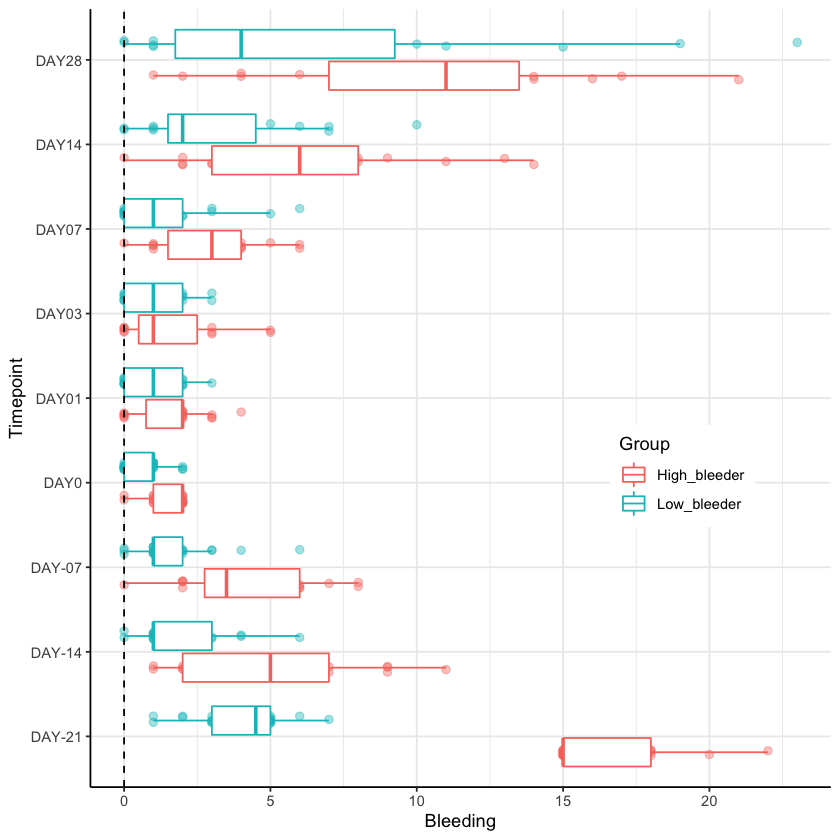

In [169]:
c_bp<-ggplot(cmd, aes(x=Timepoint, y=Bleeding)) +
    geom_jitter(aes(color=Group), position=position_jitterdodge(jitter.width= 0.2,dodge.width = 0.8),size=2,alpha=0.4) +
    geom_boxplot(aes(color=Group), outlier.shape = NA) + 
    #scale_color_manual(values=c("", ""))+
    #geom_point(aes(fill=Group), pch = 21, position = position_dodge(width = 0.8), size=1,alpha=0.6)+
    ylab("Bleeding")+
    coord_flip()+
    geom_hline(yintercept=0, linetype="dashed")+
    theme_bw()+
    theme(
        axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"),
        panel.border = element_blank())+
theme(legend.position=c(0.8, 0.4))
#theme(legend.position="none")
c_bp
ggsave(filename=paste(outpath,"/Bleeding_by_Group.pdf",sep=""), plot=c_bp, width=3, height=3)

### RF classification analysis on the Day 0 and all the other time points using `rf_clf.comps`

In [170]:
library("crossRanger")
args(rf_clf.comps)

function (df, f, comp_group, verbose = FALSE, clr_transform = TRUE, 
    rf_imp_values = FALSE, ntree = 500, p.adj.method = "bonferroni", 
    q_cutoff = 0.05) 
NULL

In [171]:
p.adj.method = "bonferroni"

In [172]:
m1_comps<-rf_clf.comps(df=f1, f=m1[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)

In [173]:
m2_comps<-rf_clf.comps(df=f2, f=m2[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)
m3_comps<-rf_clf.comps(df=f3, f=m3[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)


In [174]:
summary(m2_comps)

                  Length Class  Mode     
x_list            6      -none- list     
y_list            6      -none- list     
sample_size       6      -none- numeric  
datasets          6      -none- character
rf_model_list     6      -none- list     
rf_AUC            6      -none- numeric  
feature_imps_list 6      -none- list     

### plot_clf_res_list

In [175]:
m1_comps.summ<-plot_clf_res_list(m1_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)
m2_comps.summ<-plot_clf_res_list(m2_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)
m3_comps.summ<-plot_clf_res_list(m3_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)


Using Data_sets as id variables
Warning message:
“Removed 6 rows containing missing values (geom_bar).”Using feature, dataset, Enr as id variables
Using Data_sets as id variables
Warning message:
“Removed 6 rows containing missing values (geom_bar).”Using feature, dataset, Enr as id variables
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Using Data_sets as id variables
Warning message:
“Removed 4 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Using feature, dataset, Enr as id variables


In [176]:
names(m3_comps.summ$feature_res)

[1] "feature"              "dataset"              "rf_imps"             
 [4] "mean_all"             "var_all"              "sd_all"              
 [7] "OccRate_all"          "AUC"                  "clr_mean_all"        
[10] "clr_var_all"          "clr_sd_all"           "clr_AUC"             
[13] "mean__DAY.21"         "sd__DAY.21"           "median__DAY.21"      
[16] "log10_median__DAY.21" "OccRate__DAY.21"      "mean__DAY0"          
[19] "sd__DAY0"             "median__DAY0"         "log10_median__DAY0"  
[22] "OccRate__DAY0"        "mean_logfc"           "clr_mean__DAY.21"    
[25] "clr_sd__DAY.21"       "clr_median__DAY.21"   "clr_mean__DAY0"      
[28] "clr_sd__DAY0"         "clr_median__DAY0"     "T.test_p"            
[31] "Wilcoxon.test_p"      "T.test_p.adj"         "Wilcoxon.test_p.adj" 
[34] "IfSig"                "IfSigEnr"             "Enr"                 
[37] "mean__DAY03"          "sd__DAY03"            "median__DAY03"       
[40] "log10_median__DAY03"  "OccRate__DAY03"       "clr_mean__DAY03"     
[43] "clr_sd__DAY03"        "clr_median__DAY03"    "mean__DAY07"         
[46] "sd__DAY07"            "median__DAY07"        "log10_median__DAY07" 
[49] "OccRate__DAY07"       "clr_mean__DAY07"      "clr_sd__DAY07"       
[52] "clr_median__DAY07"    "mean__DAY28"          "sd__DAY28"           
[55] "median__DAY28"        "log10_median__DAY28"  "OccRate__DAY28"      
[58] "clr_mean__DAY28"      "clr_sd__DAY28"        "clr_median__DAY28"

In [177]:
keep_sig_markers<-function(wilcox_res, q_cutoff){
  wilcox_res_sig<-wilcox_res[which(wilcox_res[, "feature"] %in% unique(as.character(subset(wilcox_res, Wilcoxon.test_p.adj < q_cutoff)[, "feature"]))), ]
  wilcox_res_sig
}

Warning message in dir.create(dataset_path):
“'All_heatmap_out/metabolome' already exists”Using Data_sets as id variables
Warning message:
“Removed 6 rows containing missing values (geom_bar).”Using feature, dataset, Enr as id variables
Using dataset as id variables
Warning message in dir.create(dataset_path):
“'All_heatmap_out/microbiome' already exists”Using Data_sets as id variables
Warning message:
“Removed 6 rows containing missing values (geom_bar).”Using feature, dataset, Enr as id variables
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Using dataset as id variables
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message in dir.create(dataset_path):
“'All_heatmap_out/cytokine' already exists”Using Data_sets as id variables
Warning message:
“Removed 4 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing mi

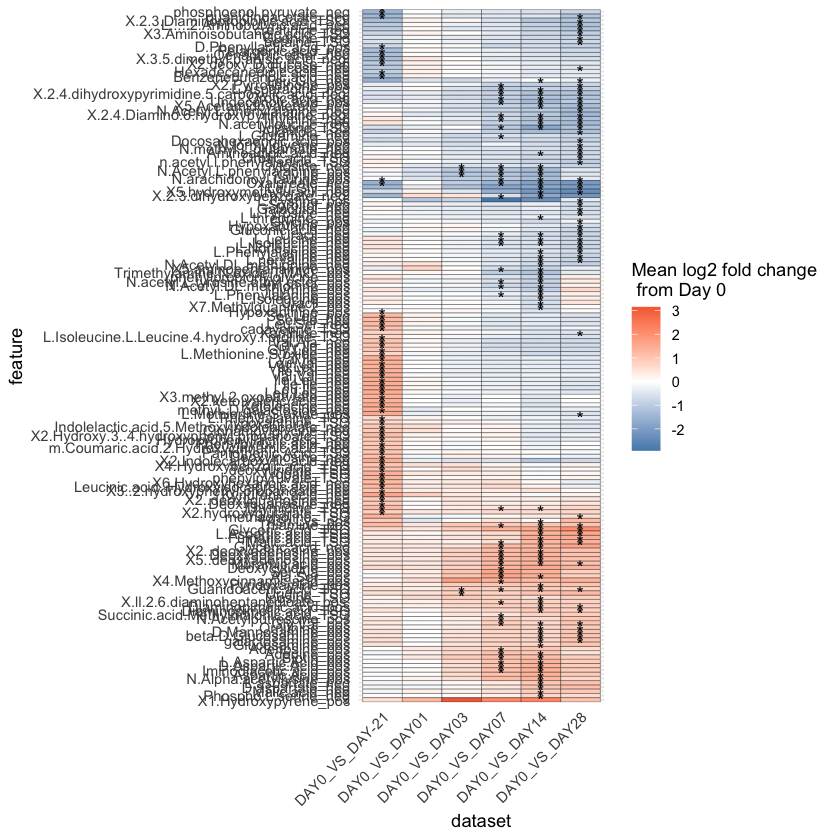

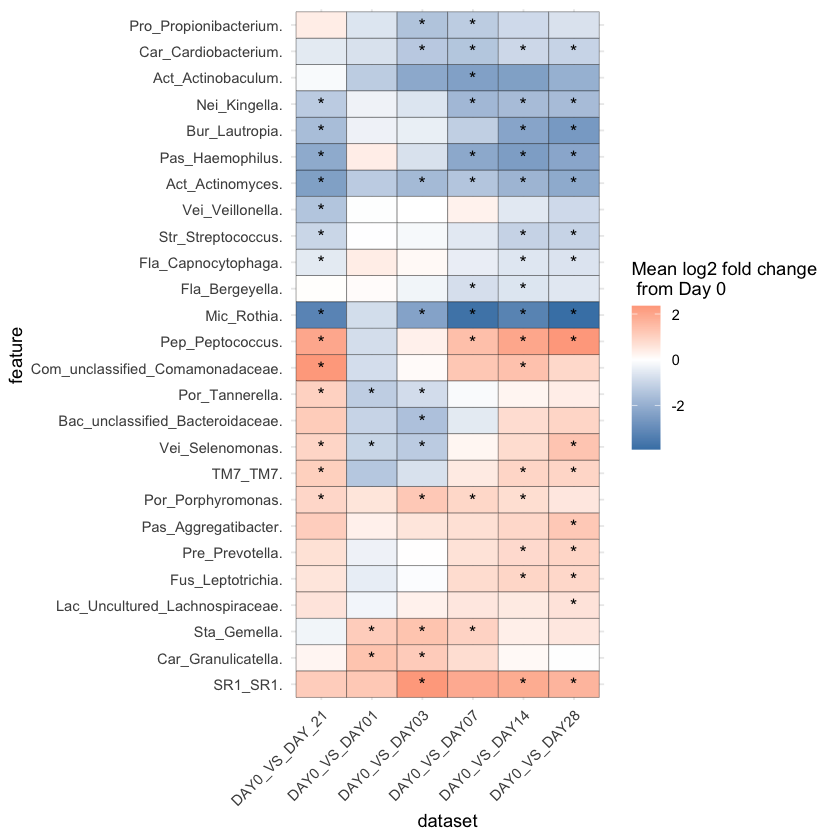

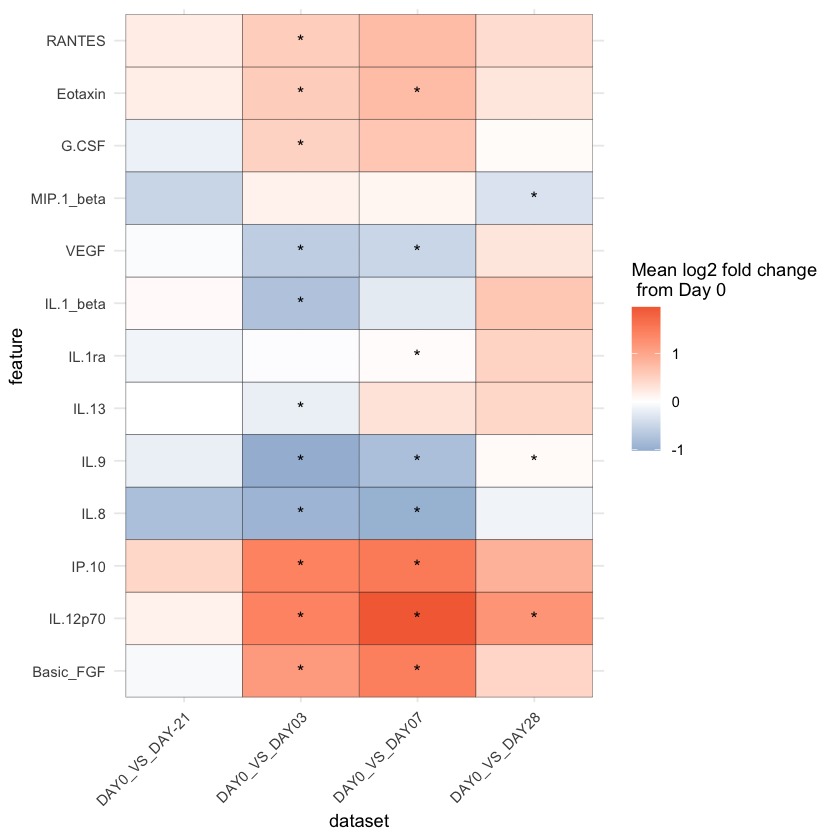

In [201]:
datasets=c('metabolome', 'microbiome', 'cytokine')
comp_group='DAY0'
q_cutoff=0.05
plot_list<-list()
for(i in 1:length(datasets)){
    ## Non-specific features across datasets (at least present in two of datasets)
    dataset_path=paste(outpath, datasets[i], "/", sep="")
    dir.create(dataset_path)
    if(i==1){
        m1_comps.summ<-plot_clf_res_list(m1_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=dataset_path)
        feature_res=m1_comps.summ$feature_res
            }else if(i==2){
        m2_comps.summ<-plot_clf_res_list(m2_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=dataset_path)
        feature_res=m2_comps.summ$feature_res
    }else{
        m3_comps.summ<-plot_clf_res_list(m3_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=dataset_path)
        feature_res=m3_comps.summ$feature_res
    }
    res_spcf<-id_non_spcf_markers(feature_res, positive_class=comp_group, other_class="Others", p.adj.method, outdir=dataset_path)
    wilcox_res_spcf_sig<-keep_sig_markers(res_spcf$feature_res_spcf, q_cutoff=q_cutoff)
sink(paste(dataset_path,"/BetweenGroupTest_out_all.xls",sep=""));write.table(wilcox_res_spcf,quote=FALSE,sep="\t", row.names = F);sink()
sink(paste(dataset_path,"/BetweenGroupTest_out_sig_",p.adj.method,"_q_cutoff_",q_cutoff,".xls",sep=""));write.table(wilcox_res_spcf_sig,quote=FALSE,sep="\t", row.names = F);sink()

#---ggplot2: heatmap in mean log2 fold change of markers across datasets
feature_logfc_dataset_df<-acast(wilcox_res_spcf_sig, feature~dataset, value.var="mean_logfc")
ord <- hclust(dist(feature_logfc_dataset_df))$order
mean_logfc_m<-wilcox_res_spcf_sig[, c("dataset", "feature", "IfSig", "Enr", "mean_logfc")]
    
#-------------------------------geom_tile
#mean_logfc_m[which(mean_logfc_m$IfSig=="NotSig"), "mean_logfc"]<-NA
mean_logfc_m$feature<-factor(mean_logfc_m$feature,levels=rownames(feature_logfc_dataset_df)[ord], ordered=TRUE)
#-------------------------------
p<-ggplot(mean_logfc_m, aes(dataset, feature) ) + #subset(mean_logfc_m, !is.na(mean_logfc))
  geom_tile(data=mean_logfc_m, na.rm = FALSE, aes(fill = -mean_logfc), colour = 'black') + # adding "-" can switch the coloring
  scale_y_discrete(label=mean_logfc_m$feature[ord])+
  labs(fill="Mean log2 fold change \n from Day 0")+
  #ylab("cytokines")+
  #scale_fill_continuous(type = "viridis", na.value = 'salmon')+
  geom_text(aes(label = paste(ifelse(IfSig=="Sig", "*", ""),  sep="" )), color = "black") +
  theme_bw()+ theme_minimal()+
  theme(axis.text.x=element_text(angle=45,hjust=1))+
  scale_fill_gradient2(high ="#f46d43", mid="white", low= "steelblue", na.value = NA)

plot_list[[i]]<-p
    print(plot_list[[i]])
#ggsave(filename=paste(dataset_path,"Markers_mean_logfc_VS_dataset_",p.adj.method,"_",comp_group, "_by_timepoint.heatmap.ggplot.pdf",sep=""),plot=p, width=18)

}



## redraw the heatmaps

In [179]:
p1<-plot_list[[1]] + coord_flip()
ggsave(filename=paste(outpath, datasets[1],"/Markers_mean_logfc_VS_dataset_",p.adj.method,"_",
                      comp_group, "_by_timepoint.heatmap.ggplot.pdf",sep=""),plot=p1, width=30, height=5)


In [180]:
p2<-plot_list[[2]] 
ggsave(filename=paste(outpath, datasets[2],"/Markers_mean_logfc_VS_dataset_",p.adj.method,"_",
                      comp_group, "_by_timepoint.heatmap.ggplot.pdf",sep=""),plot=p2, width=6, height=7)


In [181]:
p3<-plot_list[[3]] 
ggsave(filename=paste(outpath, datasets[3],"/Markers_mean_logfc_VS_dataset_",p.adj.method,"_",
                      comp_group, "_by_timepoint.heatmap.ggplot.pdf",sep=""),plot=p3, width=5, height=7)


## Data normalization for heat map

### plaque metabolome

In [182]:
library('compositions')
library('viridis')

In [183]:
dim(f1)

[1]  275 1125

In [184]:
min(f1[f1>0])/2

[1] 3.316805e-07

In [185]:
library(RColorBrewer)
library(viridis)
mat1<-f1[order(m1$Timepoint),]
#mat1<-t(apply(mat1, 2, rank))
t_mat1<-t(log_mat(mat1, base=10, peudozero = max(min(f1)/2, 1e-08)))
m1_sorted<-m1[order(m1$Timepoint),]

In [186]:
identical(rownames(m1_sorted), colnames(t_mat1))

[1] TRUE

In [187]:
# Data frame with column annotations.
mat_col <- data.frame(Timpoint = m1_sorted$Timepoint, Bleeding=m1_sorted$Bleeding)
rownames(mat_col) <- colnames(t_mat1)

# List with colors for each annotation.
mat_colors <- list(Timpoint = c("darkblue", brewer.pal(nlevels(m1_sorted$Timepoint)-1, "Blues")), 
                   Bleeding = viridis(n = 10))
names(mat_colors$Timpoint) <- unique(m1_sorted$Timepoint)

In [188]:
t_mat1<-t(apply(t_mat1, 1, rank))
dim(t_mat1)

[1] 1125  275

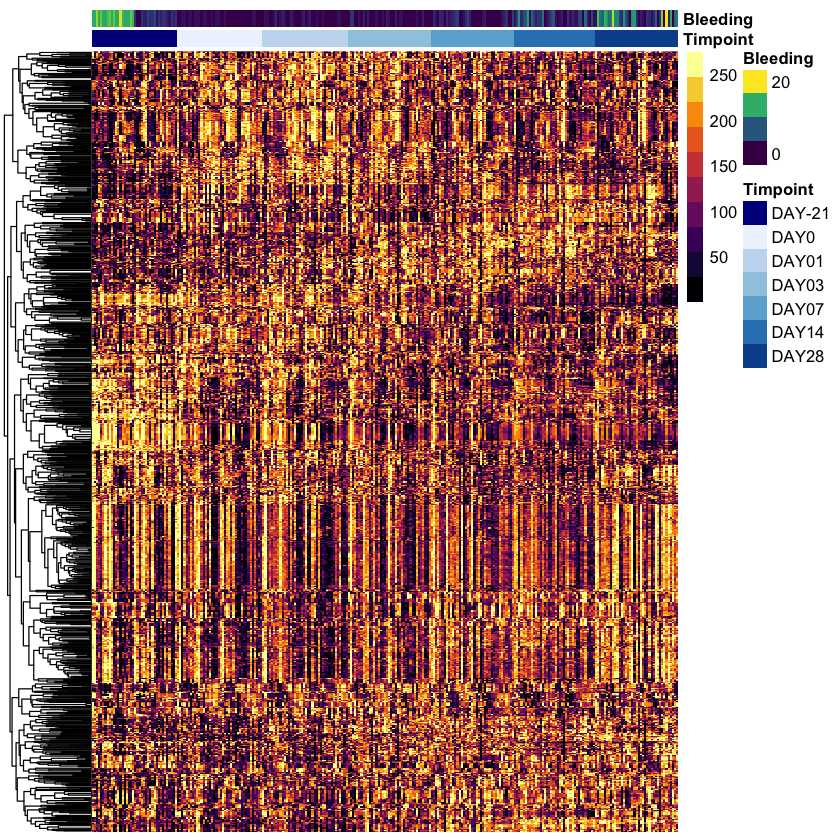

In [189]:
pheatmap(t_mat1, cluster_cols = F, color =inferno(10),
  border_color      = NA,
  show_colnames     = FALSE,
  show_rownames     = FALSE,
  annotation_col    = mat_col,
  annotation_colors = mat_colors)

### microbiota

In [190]:
f2_s_clr<-t(apply(f2_s, 1, clr))
f2_clr<-t(apply(f2, 1, clr))
f2_clr0<-f2_clr[order(m2$Timepoint), ]
t_mat2<-t(f2_clr0)
m2_sorted<-m2[order(m2$Timepoint),]
identical(rownames(m2_sorted), colnames(t_mat2))

[1] TRUE

In [191]:
library(RColorBrewer)
library(viridis)
# Data frame with column annotations.
mat_col <- data.frame(Timpoint = m2_sorted$Timepoint, Bleeding=m2_sorted$Bleeding)
rownames(mat_col) <- colnames(t_mat2)

# List with colors for each annotation.
mat_colors <- list(Timpoint = c("darkblue", brewer.pal(nlevels(m1_sorted$Timepoint)-1, "Blues")), 
                   Bleeding = viridis(n = 10))
names(mat_colors$Timpoint) <- unique(m2_sorted$Timepoint)

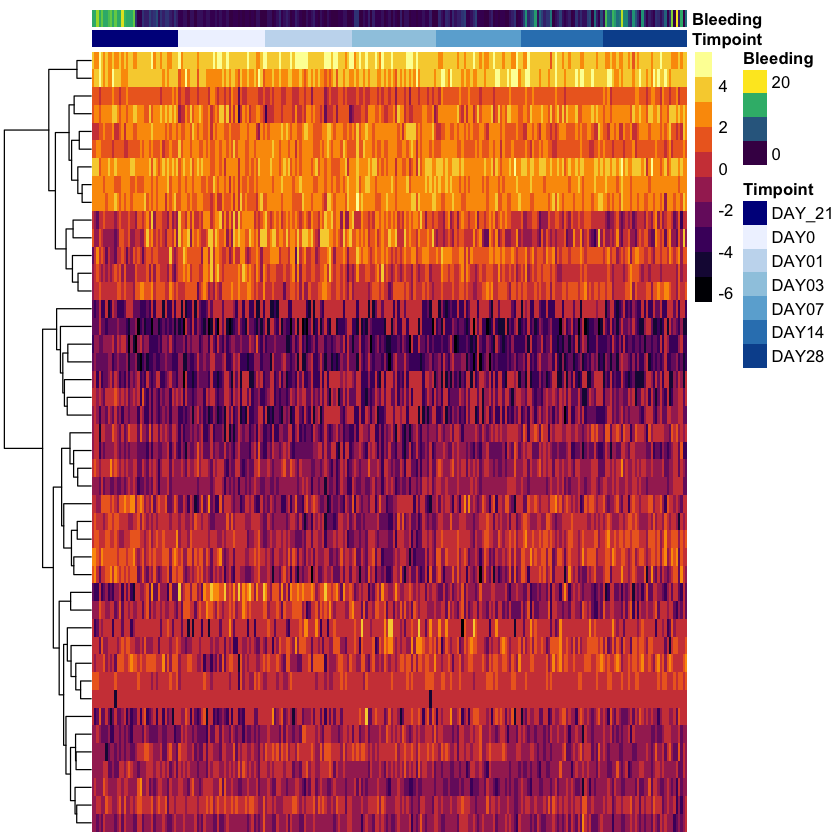

In [192]:
pheatmap(t_mat2, cluster_cols = F, color =inferno(10),
  border_color      = NA,
  show_colnames     = FALSE,
  show_rownames     = FALSE,
  annotation_col    = mat_col,
  annotation_colors = mat_colors)


## To merge all samples from three omics datasets

In [193]:
f1ID<-data.frame(SampleID=rownames(f1), f1)
f2ID<-data.frame(SampleID=rownames(f2), f2)
f3ID<-data.frame(SampleID=rownames(f3), f3)

In [194]:
tmp<-merge(f2ID, f1ID, by="SampleID", all = TRUE)
fID_all<-merge(tmp, f3ID, by="SampleID", all=TRUE)
head(fID_all)

SampleID,Act_Actinobaculum.,Act_Actinomyces.,Aer_Abiotrophia.,Bac_unclassified_Bacteroidaceae.,Bur_Lautropia.,Cam_Campylobacter.,Car_Cardiobacterium.,Car_Granulicatella.,Clo_Parvimonas.,⋯,MCP.1,IL.8,MIP.1_alpha,IL.10,G.CSF,IL.15,IL.7,IL.12p70,IL.17A,IL.9
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
H3003_0,0.000382885,0.02065710,0.00e+00,0.002773580,0.09287290,0.00365608,0.00381017,0.00728415,0.000644367,⋯,16.16,3580.00,0.30,1.02,7.53,46.89,0.93,0.41,6.60,13.57
H3003_1,0.000073100,0.00700565,0.00e+00,0.000701296,0.09088360,0.00293668,0.00135876,0.01183440,0.000175324,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
H3003_14,0.000115982,0.01457380,6.52e-05,0.014526700,0.02094200,0.02551960,0.00961200,0.00258785,0.000674145,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
H3003_21b,0.000209918,0.00212017,0.00e+00,0.060229700,0.00853947,0.01932090,0.00236788,0.00153660,0.000906846,⋯,100.75,820.64,0.89,0.59,22.19,29.54,1.92,0.32,3.25,6.71
H3003_28,0.000212330,0.00575740,0.00e+00,0.006712890,0.01131880,0.04339690,0.00849319,0.00470392,0.000081700,⋯,83.81,1869.00,0.57,1.08,18.24,33.88,2.08,0.83,3.97,7.06
H3003_3,0.000037800,0.00161833,0.00e+00,0.003060350,0.12137500,0.00646075,0.00100123,0.00938886,0.000573029,⋯,186.79,1641.00,0.98,3.36,53.28,66.32,3.34,1.45,4.17,7.06


In [195]:
f_all<-fID_all[,-1]
sample_md_all<-m2

In [196]:
dim(f_all)


[1]  275 1196

In [197]:
head(t_mat1)

,H3003_21b,H3007_21b,H3008_21b,H3012_21b,H3015_21b,H3016_21b,H3034_21b,H3046_21b,H3047_21b,H3052_21b,⋯,L5092_28,L5114_28,L7008_28,L7042_28,L8011_28,L8018_28,L9011_28,L9030_28,L9148_28,L9158_28
Pantothenic.Acid_TSQ,237,256,272,203,275,264,223,265,228,166,⋯,81,123,198,59,95,9,5,35,116,64
Xanthine_neg,267,271,241,210,275,260,252,264,270,231,⋯,107,142,118,51,98,25,35,3,61,32
X2.keto.valeric.acid_neg,273,275,254,194,266,263,260,262,274,267,⋯,191,181,205,105,160,31,106,88,138,145
X3.methyl.2.oxobutyrate_neg,273,275,254,194,266,263,260,262,274,267,⋯,191,181,204,110,160,30,105,86,138,145
Acetylphosphate._neg,3,2,1,57,56,12,115,25,5,72,⋯,248,144,31,89,40,231,26,201,66,70
Ketoleucine_neg,274,275,252,193,258,262,248,253,271,259,⋯,167,199,206,82,183,65,107,72,164,146


In [198]:
library(RColorBrewer)
library(viridis)
# Data frame with column annotations.
mat_col <- data.frame(Timpoint = m1_sorted$Timepoint, Bleeding=m1_sorted$Bleeding)
rownames(mat_col) <- colnames(t_mat1)

# List with colors for each annotation.
mat_colors <- list(Timpoint = c("darkblue", brewer.pal(nlevels(m1_sorted$Timepoint)-1, "Blues")), 
                   Bleeding = viridis(n = 10))
names(mat_colors$Timpoint) <- unique(m1_sorted$Timepoint)

In [199]:
pheatmap(t(f_all), 
         cluster_cols = F, color =inferno(10),
         border_color      = NA,
         show_colnames     = FALSE,
         show_rownames     = FALSE,
         #annotation_col    = mat_col,
         #annotation_colors = mat_colors,
         filename = paste(outpath,"ALL_VS_dataset_heatmap.pdf",sep="")
        )

In [200]:
## pheatmap: heatmap in mean log2 fold change of markers across datasets
head(logfc_dataset_df)

#---ggplot2: heatmap in mean log2 fold change of markers across datasets
feature_logfc_dataset_df<-acast(wilcox_res_spcf_sig, feature~dataset, value.var="mean_logfc")
sink(paste(outpath, "feature_logfc_dataset_df.xls",sep="\t"));cat("Taxon\t"); 
write.table(feature_logfc_dataset_df, sep="\t", quote=F, row.names = T)
sink()
feature_ord <- hclust(dist(feature_logfc_dataset_df))$order
dataset_ord <- hclust(dist(t(feature_logfc_dataset_df)))$order
mean_logfc_m<-wilcox_res_spcf_sig[, c("dataset", "feature", "IfSig", "Enr", "mean_logfc")]
#-------------------------------barchart
p_logfc<-ggplot(mean_logfc_m, aes(x=feature, y=mean_logfc, fill=Enr)) + scale_fill_manual(values = my3cols) +
  geom_bar(stat="identity", alpha=.5) + ylab("mean log2(fold change)")+
  coord_flip()+ # if want to filp coordinate 
  theme_bw()+
  facet_wrap(~ dataset, nrow=1)+
  theme(axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"), 
        panel.border = element_blank())
ggsave(filename=paste(outpath,"Markers_logfc_",p.adj.method,"_",c_category, "_by_", s_category,".barplot.pdf",sep=""),plot=p_logfc, width=20, height=10)
#-------------------------------geom_tile
mean_logfc_m[which(mean_logfc_m$IfSig=="NotSig"), "mean_logfc"]<-NA
mean_logfc_m$feature<-factor(mean_logfc_m$feature,levels=rownames(feature_logfc_dataset_df)[feature_ord], ordered=TRUE)
mean_logfc_m$dataset<-factor(mean_logfc_m$dataset,levels=colnames(feature_logfc_dataset_df)[dataset_ord], ordered=TRUE)
head(mean_logfc_m)
#-------------------------------
p<-ggplot(mean_logfc_m, aes(x=dataset, y=feature) ) + #subset(mean_logfc_m, !is.na(mean_logfc))
  geom_tile(data=mean_logfc_m, na.rm = FALSE, aes(fill = -mean_logfc), colour = 'black') + # adding "-" can switch the coloring
  scale_y_discrete(label=mean_logfc_m$feature[feature_ord])+
  labs(fill="Mean log2 fold change")+
  #scale_fill_continuous(type = "viridis", na.value = 'salmon')+
  theme_bw()+ theme_minimal()+
  theme(axis.text.x=element_text(angle=90,hjust=1))+
  scale_fill_gradient2(high ="#f46d43", mid="white", low= "steelblue", na.value = NA)
p
ggsave(filename=paste(outpath,"Markers_mean_logfc_VS_dataset_",p.adj.method,"_", c_category, "_by_", s_category,".heatmap.ggplot.pdf",sep=""),plot=p, width=6, height=9)
#------------------------------- transposed
p<-ggplot(mean_logfc_m, aes(x=feature, y=dataset) ) + #subset(mean_logfc_m, !is.na(mean_logfc))
  geom_tile(data=mean_logfc_m, na.rm = FALSE, aes(fill = -mean_logfc), colour = 'black') + # adding "-" can switch the coloring
  scale_x_discrete(label=mean_logfc_m$feature[feature_ord])+
  labs(fill="Mean log2 fold change")+
  theme_bw()+ theme_minimal()+
  #scale_fill_continuous(type = "viridis", na.value = 'salmon')+
  theme(axis.text.x=element_text(angle=90,hjust=1), panel.border = element_blank())+
  scale_fill_gradient2(high ="#f46d43", mid="white", low= "steelblue", na.value = NA) 
p
ggsave(filename=paste(outpath,"Markers_mean_logfc_VS_dataset_",p.adj.method,"_", c_category, "_by_", s_category,".heatmap.ggplot.t.pdf",sep=""),plot=p, width=10, height=5)


#-------------------------------
# AUC
#-------------------------------
l_m<-melt(wilcox_res_spcf_sig[, c("feature", "dataset","AUC", "IfSigEnr", "Enr")])
l_m$feature<-factor(l_m$feature,levels=rownames(feature_logfc_dataset_df)[feature_ord], ordered=TRUE)
p_auc<-ggplot(l_m, aes(x=feature, y=value, color=Enr)) + ylim(0.5, 1) + ylab("AUC")+ scale_color_manual(values = my3cols) +
  geom_abline(slope=0, intercept=0.5,  col = "black", lty=2) +
  geom_point(aes(colour=Enr), shape="diamond", size=4) +
  coord_flip()+ # if want to filp coordinate
  theme_bw()+
  facet_wrap(~ dataset, nrow=1)+
  theme(axis.line = element_line(color="black"),
        strip.background = element_rect(colour = "white"), 
        panel.border = element_blank())
ggsave(filename=paste(outpath,"Markers_AUC_sig_",p.adj.method, ".", c_category, "_by_", s_category,".scatterplot.pdf",sep=""),plot=p_auc,width=10,height=10)



ERROR: Error in head(logfc_dataset_df): object 'logfc_dataset_df' not found


In [ ]:
sessionInfo()